In [1]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/Deep Learning and Generative AI/breast_cancer/Dataset_BUSI_with_GT"

In [3]:
# import relevant libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

%matplotlib inline

In [4]:
from PIL import Image

healthy_imgs = []
for file in os.listdir(train_path + "/normal"):
  if 'mask' not in file:
    img_path = os.path.join(train_path, "normal", file)

    # load and convert to grayscale
    img = Image.open(img_path).convert("L") # "L" mode = Grayscale
    img = img.resize((224, 224)) # resize to 45x45
    healthy_imgs.append(img)

healthy_imgs = np.array(healthy_imgs, dtype=np.float32) / 127.5 - 1.0 # normalize
healthy_imgs = np.expand_dims(np.array(healthy_imgs), axis=-1)

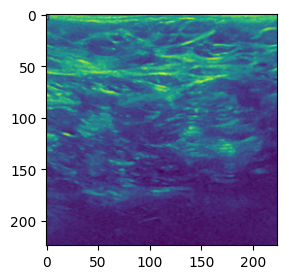

In [5]:
plt.figure(figsize=(4,3))
plt.imshow(healthy_imgs[10])

In [6]:
healthy_imgs.shape

(133, 224, 224, 1)

In [7]:
healthy_imgs.min()

-1.0

In [8]:
healthy_imgs.max()

1.0

## Filtering out the Data for Faster Training on Smaller Dataset

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose,Cropping2D,Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [10]:
codings_size = 500

In [11]:
generator = Sequential()

# start with a Dense layer and reshape to 7x7x128
generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())

# first upsampling: 7x7 -> 14x14
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# second upsampling: 14x14 -> 28x28
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# third upsampling: 28x28 -> 56x56
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# fourth upsampling: 56x56 -> 112x112
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# fifth upsampling: 112x112 -> 224x224
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())

# output layer
generator.add(Conv2DTranspose(1, kernel_size=5, strides=1, padding="same", activation="tanh"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[224, 224, 1]))
discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))

discriminator.add(Flatten())

discriminator.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
GAN = Sequential([generator, discriminator])

In [14]:
optimizer = Adam(learning_rate=0.00005,beta_1=0.5,clipvalue=1.5)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
discriminator.trainable = False

In [15]:
optimizer = Adam(learning_rate=0.0001,beta_1=0.5)
GAN.compile(loss="binary_crossentropy", optimizer=optimizer)

In [16]:
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 1)         │       2,370,785 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         608,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,978,786 (11.36 MB)

 Trainable params: 2,369,889 (9.04 MB)

 Non-trainable params: 608,897 (2.32 MB)

In [17]:
GAN.layers[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │       1,574,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 56, 56, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 112, 112, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 224, 224, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 224, 224, 1)         │             801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,370,785 (9.04 MB)

 Trainable params: 2,369,889 (9.04 MB)

 Non-trainable params: 896 (3.50 KB)

In [18]:
GAN.layers[1].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         401,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 608,001 (2.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 608,001 (2.32 MB)

In [19]:
def epoch_plot(ep):
    noise = tf.random.normal(shape=[10, codings_size])
    images = generator(noise)
    plt.figure(figsize=(4,3))
    plt.imshow(images[0].numpy().reshape(224,224,1))
    plt.title('Epoch {}'.format(ep+1),fontsize=14)
    plt.show()

In [20]:
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss", color='red')
    plt.plot(g_losses, label="Generator Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Losses during GAN training")
    plt.grid(True)
    # plt.savefig("gan_loss_plot.png")
    plt.show()

### Setting up Training Batches

In [21]:
import tensorflow as tf

In [22]:
batch_size = 32

In [23]:
dataset = tf.data.Dataset.from_tensor_slices(healthy_imgs).shuffle(buffer_size=1000)

In [24]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [25]:
epochs = 1500

In [26]:
# grab the seprate components
generator, discriminator = GAN.layers

d_losses = [] # list to track discriminator losses
g_losses = [] # list to track generator losses

for epoch in range(epochs):
    epoch = epoch-1
    print(f"Currently on Epoch {epoch+1}")

    i = 0
    for X_batch in dataset:

        # training the discriminator
        epoch_d_losses = [] # track losses for each epoch
        epoch_g_losses = [] # track losses for each epoch

        noise = tf.random.normal(shape=[batch_size, codings_size]) # create noise

        gen_images = generator(noise) # generate based on noise

        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0) # join generated against the real

        y1 = tf.constant([[0.1]] * batch_size + [[.9]] * batch_size) # target - zero for fake and one for real

        discriminator.trainable = True

        d_loss = discriminator.train_on_batch(X_fake_vs_real, y1) # train discriminator

        epoch_d_losses.append(d_loss)

        # training the generator
        noise = tf.random.normal(shape=[batch_size, codings_size]) # create noise

        y2 = tf.constant([[.9]] * batch_size) # discriminator belives fake are real

        discriminator.trainable = False

        g_loss = GAN.train_on_batch(noise, y2) # train generator

        epoch_g_losses.append(g_loss)

    # calculate average losses for this epoch
    avg_d_loss = np.mean(epoch_d_losses)
    avg_g_loss = np.mean(epoch_g_losses)

    # store the average losses
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    if (epoch+1) % 50 == 0: # print every 50 epochs
      print(f"Discriminator Loss: {avg_d_loss:.4f}\tGenerator Loss: {avg_g_loss:.4f}") # print current loss values for GAN
      epoch_plot(epoch) # plot example image based on trained generator

# plot losses - post training
print("\n")
plt.figure(figsize=(10, 6))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

print("\n*****Training Completed!*****\n")

Output hidden; open in https://colab.research.google.com to view.

In [31]:
noise = tf.random.normal(shape=[10, codings_size]) # example noise to test generator after training

In [32]:
images = generator(noise) # get images based on trained generator

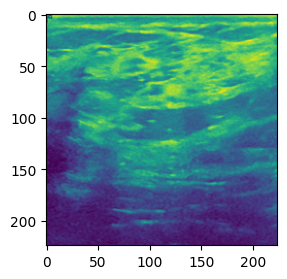

In [33]:
plt.figure(figsize=(4,3))
plt.imshow(healthy_imgs[3]) # show example of expected generator output

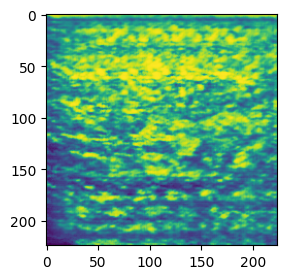

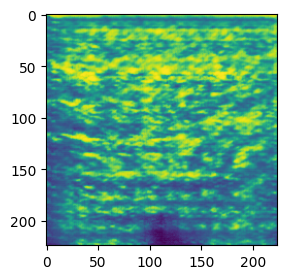

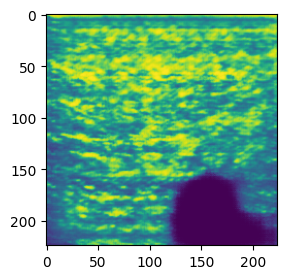

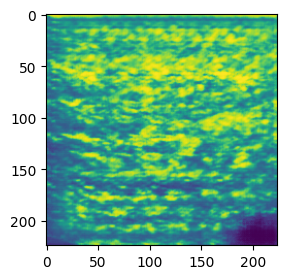

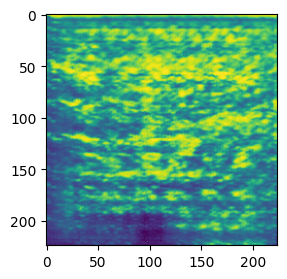

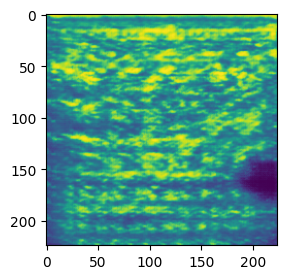

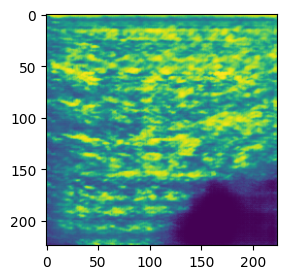

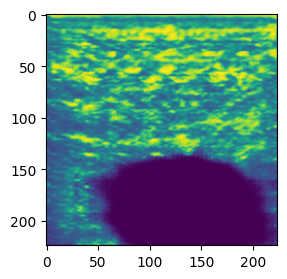

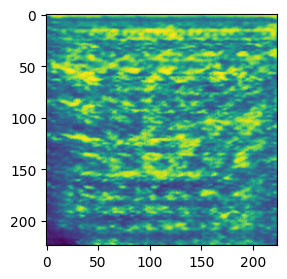

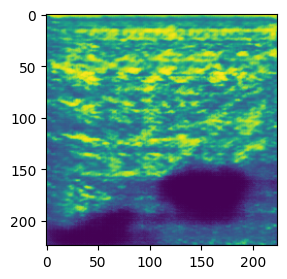

In [34]:
# loop to plot generated images
for image in images:
    plt.figure(figsize=(4,3))
    plt.imshow(image.numpy().reshape(224,224,1))
    plt.show()
    print("\n")

In [36]:
generator.save("generator_model_breast.keras")